# Imports and data preparation

## Imports

In [ ]:
!pip install gputil
!pip install psutil
!pip install humanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=3ba68c17768aada7c1ed54e8da7926da38669b77b8159887bf271bdc6be94413
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
import os
from time import time

import torch

import sys,humanize,psutil,GPUtil
from skimage import filters
from skimage.util import random_noise
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import img_as_ubyte

## GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Thu Oct 20 22:10:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Define function
def mem_report():

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  print()

  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))

  if torch.cuda.is_available():
    GPUs = GPUtil.getGPUs()
    for i, gpu in enumerate(GPUs):
      print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

Using device: cuda

CPU RAM Free: 12.4 GB
GPU 0 ... Mem Free: 15106MB / 15109MB | Utilization   0%


## Data

### F-actin

In [ ]:
if not os.path.exists('/content/F-actin-small'):
  !wget --show-progress -O F-actin.zip https://www.dropbox.com/s/9f9xat4jbgkdchh/F-actin-small.zip?dl=0
  !unzip -q F-actin.zip
  !rm F-actin.zip

--2022-10-20 22:10:42--  https://www.dropbox.com/s/9f9xat4jbgkdchh/F-actin-small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9f9xat4jbgkdchh/F-actin-small.zip [following]
--2022-10-20 22:10:43--  https://www.dropbox.com/s/raw/9f9xat4jbgkdchh/F-actin-small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucebef8f554f926e5c7785dd2cd0.dl.dropboxusercontent.com/cd/0/inline/BvNv3FYHnfTiTxZRthHkIpk7dvUe1Fj7Q-M0u7p1hu4QNtYRUmiZtGtpdb1vGSloBdbD378tS1xkfcDGb2E5IQOGzu2kADTqfnDNi61ErkjK16CJVJQtFXzgj4-8vc5rzGaXIFTvkK1VoACNjF96PIS0f-H-cV3G8vGYJgmRtM7_Wg/file# [following]
--2022-10-20 22:10:43--  https://ucebef8f554f926e5c7785dd2cd0.dl.dropboxusercontent.com/cd/0/inline/BvNv3FYHnfTiTxZRthHkIpk7dvUe1Fj7Q-M0u7p1hu4QNtYRUmiZtGtpd

In [ ]:
data_filepath = '/content/F-actin-small/Training_dataset'
hr_data_filepath = os.path.join(data_filepath, 'HR_images')
lr_data_filepath = os.path.join(data_filepath, 'LR_images')

_, hr_extension = os.path.splitext(os.listdir(hr_data_filepath)[0])
_, lr_extension = os.path.splitext(os.listdir(lr_data_filepath)[0])

### Flowers

In [ ]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 2s 0us/step


---
# Test reading raw data

In [ ]:
mem_report()
init_time = time()

hr_images = [io.imread(os.path.join(hr_data_filepath, filename)) for filename in os.listdir(hr_data_filepath) if filename.endswith(hr_extension)]
lr_images = [io.imread(os.path.join(lr_data_filepath, filename)) for filename in os.listdir(lr_data_filepath) if filename.endswith(lr_extension)]

print('Elapsed time: {}'.format(time() - init_time))
mem_report()

Using device: cuda

CPU RAM Free: 11.5 GB
GPU 0 ... Mem Free: 14795MB / 15109MB | Utilization   2%
Elapsed time: 14.882745027542114
Using device: cuda

CPU RAM Free: 11.5 GB
GPU 0 ... Mem Free: 14795MB / 15109MB | Utilization   2%


---

#**IMPORTANT** An alternative to TensorFlow's Dataset:

Using a keras.utils.Sequence object as input

keras.utils.Sequence is a utility that you can subclass to obtain a Python generator with two important properties:

- It works well with multiprocessing.
- It can be shuffled (e.g. when passing shuffle=True in fit()).

A Sequence must implement two methods:

- \_\_getitem__
- \_\_len__

The method \_\_getitem__ should return a complete batch. If you want to modify your dataset between epochs, you may implement on_epoch_end.

Here's a quick example:

```
class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

---


# tf.data.Dataset.from_generator

## Basic use (directly)

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)


ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers),
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,256,256,3], [32,5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [ ]:
from scipy.ndimage.interpolation import zoom as npzoom

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

i=0
for images, labels in ds:
  for img in images:
    gray_img = rgb2gray(img)
    io.imsave('/content/Untitled Folder/{}.png'.format(i), gray_img)
    io.imsave('/content/Untitled Folder 1/{}.png'.format(i), npzoom(gray_img, 1/2, order=1))
    i += 1
  if i >1500:
    break
  print(images.shape)

Found 3670 images belonging to 5 classes.


FileNotFoundError: ignored

In [ ]:
images = list(ds.take(1))

plt.imshow(images[0][0,:,:,0])

Found 3670 images belonging to 5 classes.


TypeError: ignored

In [ ]:
images, labels = list(images)

ValueError: ignored

Found 3670 images belonging to 5 classes.
label:  tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


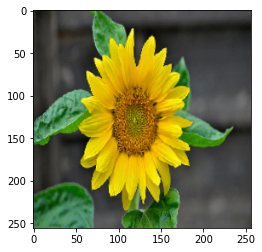

In [ ]:
for images, labels in ds.take(1):
  plt.imshow(images[0])
  print('label: ', labels[0])

## More complex (using a class)

In [ ]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

 # tf.data.Dataset.from_tensor_slices

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)


# tf.data.TFRecordDataset

The filenames argument to the TFRecordDataset initializer can either be a string, a list of strings, or a tf.Tensor of strings. Therefore if you have two sets of files for training and validation purposes, you can create a factory method that produces the dataset, taking filenames as an input argument:

In [ ]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
fsns_test_file

7904079/7904079 [==============================] - 0s 0us/step


'/root/.keras/datasets/fsns.tfrec'

In [ ]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())
parsed

# Additional functions



## Extract data batches: batch()

The simplest form of batching stacks n consecutive elements of a dataset into a single element. The **Dataset.batch()** transformation does exactly this, with the same constraints as the **tf.stack()** operator, applied to each component of the elements: i.e. for each component i, all elements must have a tensor of the exact same shape.

```
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]
```

Use the **drop_remainder** argument to ignore that last batch, and get full shape propagation.

## Repeat dataset: repeat()

Applying the **Dataset.repeat()** transformation with no arguments will repeat the input indefinitely.

The **Dataset.repeat** transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a **Dataset.batch** applied after **Dataset.repeat** will yield batches that straddle epoch boundaries.

```
titanic_batches = titanic_lines.repeat(3).batch(128)
```

![picture](https://www.tensorflow.org/static/guide/data_files/output_nZ0G1cztoSHX_0.png)

If you need clear epoch separation, put **Dataset.batch** before the **Dataset.repeat**:

```
titanic_batches = titanic_lines.batch(128).repeat(3)
```

![picture](https://www.tensorflow.org/static/guide/data_files/output_wmbmdK1qoSHS_0.png)





## Shuffle data inside a buffer: shuffle()

The **Dataset.shuffle()** transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.

```
dataset.shuffle(buffer_size=100).batch(20)

```

Since the buffer_size is 100, and the batch size is 20, the first batch contains no elements with an index over 120.

As with **Dataset.batch** the order relative to **Dataset.repeat** matters.

**Dataset.shuffle** doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next:

```
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)
```

![picture](https://www.tensorflow.org/static/guide/data_files/output_VAM4cbpZoSGL_1.png)

## Apply function to dataset's elements: map()

The **Dataset.map(f)** transformation produces a new dataset by applying a given function f to each element of the input dataset. It is based on the *map()* function that is commonly applied to lists (and other structures) in functional programming languages. The function f takes the **tf.Tensor** objects that represent a single element in the input, and returns the **tf.Tensor** objects that will represent a single element in the new dataset. Its implementation uses standard TensorFlow operations to transform one element into another.

### Vectorizing mapping

Invoking **map** transformation has overhead, therefore in order to improve its performance vectoried mapping should be done instead of scalar mapping.

Scalar mapping:

```
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)
```

![picture](https://www.tensorflow.org/guide/images/data_performance/scalar_map.svg)

vectorized mapping:

```
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)
```

![picture](https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg)


## Overlap preprocessing: prefetch()

The **tf.data** API provides the **tf.data.Dataset.prefetch** transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.AUTOTUNE**, which will prompt the **tf.data** runtime to tune the value dynamically at runtime.

Without prefetching:
![picture](https://www.tensorflow.org/guide/images/data_performance/naive.svg)

With prefetching:
![picture](https://www.tensorflow.org/guide/images/data_performance/prefetched.svg)

## Paralelize data extraction: interleave()

The **tf.data.Dataset**.interleave transformation can be used to parallelize the data loading step, interleaving the contents of other datasets (such as data file readers). The number of datasets to overlap can be specified by the **cycle_length** argument, while the level of parallelism can be specified by the **num_parallel_calls** argument. Similar to the prefetch transformation, the **interleave()** transformation supports **tf.data.AUTOTUNE**, which will delegate the decision about what level of parallelism to use to the **tf.data** runtime.

- Sequential:

```
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
      lambda _: ArtificialDataset()
    )
)
```

![picture](https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg)

- Parallel:

```
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
      lambda _: ArtificialDataset(),
      num_parallel_calls=tf.data.AUTOTUNE
    )
)
```

![picture](https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg)


## Caching the dataset: cache()

The **tf.data.Dataset.cache** transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

![picture](https://www.tensorflow.org/guide/images/data_performance/cached_dataset.svg)

Here, the data execution time plot shows that when you **cache** a dataset, the transformations before the cache one (like the file opening and data reading) are executed only during the first epoch. The next epochs will reuse the data cached by the **cache** transformation.

If the user-defined function passed into the **map** transformation is expensive, apply the **cache** transformation after the **map** transformation as long as the resulting dataset can still fit into memory or local storage. If the user-defined function increases the space required to store the dataset beyond the cache capacity, either apply it after the **cache** transformation or consider pre-processing your data before your training job to reduce resource usage.

## Advise: Reducing memory footprint

A number of transformations, including **interleave**, **prefetch**, and **shuffle**, maintain an internal buffer of elements. If the user-defined function passed into the **map** transformation changes the size of the elements, then the ordering of the map transformation and the transformations that buffer elements affects the memory usage. In general, choose the order that results in lower memory footprint, unless different ordering is desirable for performance.

**IMPORTANT:** It is recommended to **cache** the dataset after the **map** transformation except if this transformation makes the data too big to fit in memory.

```
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

# Testing how to fit the datasets to a model

## Fashion_mnist dataset

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 8s 3ms/step - loss: 0.6016 - accuracy: 0.7969
Epoch 2/2
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4610 - accuracy: 0.8433


In [ ]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)


10/10 [==============================] - 0s 3ms/step - loss: 0.5313 - accuracy: 0.8281
Loss : 0.5312919020652771
Accuracy : 0.828125


In [ ]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

10/10 [==============================] - 0s 4ms/step
(320, 10)


## F-actin dataset

### With generator

In [ ]:
def load_single_image(hr_path, lr_path):
  _, hr_extension = os.path.splitext(os.listdir(hr_path)[0])
  _, lr_extension = os.path.splitext(os.listdir(lr_path)[0])

  hr_filenames = [os.path.join(hr_path, filename) for filename in os.listdir(hr_path) if filename.endswith(hr_extension)]
  lr_filenames = [os.path.join(lr_path, filename) for filename in os.listdir(lr_path) if filename.endswith(lr_extension)]

  random_index = np.random.randint(0, len(hr_filenames))

  hr_image = io.imread(hr_filenames[random_index])[0:200, 0:200]
  lr_image = io.imread(lr_filenames[random_index])[0:100, 0:100]

  hr_image = np.expand_dims(hr_image, axis=-1)
  lr_image = np.expand_dims(lr_image, axis=-1)

  yield ([lr_image], [hr_image])


ds = tf.data.Dataset.from_generator(
    lambda: load_single_image(hr_data_filepath, lr_data_filepath),
    output_types=(tf.float64,tf.float64)
).repeat(1600)


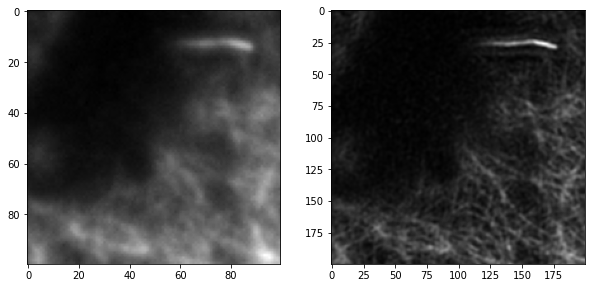

In [ ]:
lr_img, hr_img = next(iter(ds))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(lr_img[0,:,:,0], 'gray')
plt.subplot(1,2,2)
plt.imshow(hr_img[0,:,:,0], 'gray')

In [ ]:
inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])


In [ ]:
model.fit(ds)

1600/1600 [==============================] - 215s 134ms/step - loss: 4778956.0000 - mean_squared_error: 4778961.0000


In [ ]:
imgs_to_predict = np.expand_dims([x[:500,:500] for x in lr_images],axis=-1)
grnd_imgs = np.expand_dims([x[:1000,:1000] for x in hr_images],axis=-1)
predictions = model.predict(imgs_to_predict)

8/8 [==============================] - 16s 2s/step


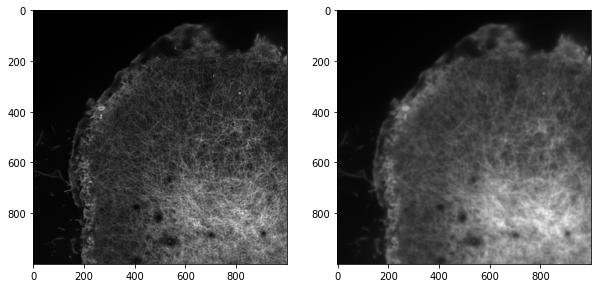

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(grnd_imgs[0,:,:,0], 'gray')
plt.subplot(1,2,2)
plt.imshow(predictions[0,:,:,0],'gray')

### With generator and Class

#### Simple version (all in the generator)

In [ ]:
def em_crappify(img, scale):
    ''' Degradates and downscales the given image, simuating
        the degradation that a electron microscopy would suffer.
        Source https://www.biorxiv.org/content/10.1101/740548v3.
    Args:
        img (array): image that whose low resolution counterpart will be calcualted.
        scale (int): scale factor for the image downscaling. Example: 2.
    Returns:
        Low resolution image obtained from degradatin the received high resolution image.
    '''
    img = filters.gaussian(img, sigma=3) + 1e-6
    return npzoom(img, 1/scale, order=1)

def fluo_crappify(img,scale):
    ''' Degradates and downscales the given image, simuating
        the degradation that a fluorescence microscopy would suffer.
        Source https://www.biorxiv.org/content/10.1101/740548v3.
    Args:
        img (array): image that whose low resolution counterpart will be calcualted.
        scale (int): scale factor for the image downscaling. Example: 2.
    Returns:
        Low resolution image obtained from degradatin the received high resolution image.
    '''
    img = random_noise(img, mode='salt', amount=0.005)
    img = random_noise(img, mode='pepper', amount=0.005)
    img = filters.gaussian(img, sigma=5) + 1e-10
    return npzoom(img, 1/scale, order=1)

class MicroscopyDataset:
    def __init__(self, patch_size_x, patch_size_y,
                 down_factor, rotation=False,
                 horizontal_flip=False, vertical_flip=False,
                 validation=False, validation_split=None,
                 hr_imgs_basedir="", lr_imgs_basedir="",
                 only_high_resolution_data=False,
                 only_hr_imgs_basedir="",
                 type_of_data="Electron microscopy"):

        if only_high_resolution_data:
            used_hr_imgs_basedir = only_hr_imgs_basedir
        else:
            used_hr_imgs_basedir = hr_imgs_basedir

        _, hr_extension = os.path.splitext(os.listdir(used_hr_imgs_basedir)[0])

        hr_filenames = [used_hr_imgs_basedir + '/' + x for x in os.listdir(used_hr_imgs_basedir) if x.endswith(hr_extension)]
        hr_filenames.sort()

        if validation_split is not None:
            val_files = int(len(hr_filenames) * validation_split)
            if validation:
                self.hr_img_names = hr_filenames[:val_files]
            else:
                self.hr_img_names = hr_filenames[val_files:]
        else:
            self.hr_img_names = hr_filenames

        if not only_high_resolution_data:
            _, lr_extension = os.path.splitext(os.listdir(lr_imgs_basedir)[0])

            lr_filenames = [lr_imgs_basedir + '/' + x for x in os.listdir(lr_imgs_basedir) if x.endswith(lr_extension)]
            lr_filenames.sort()

            if validation_split is not None:
                val_lr_files = int(len(lr_filenames) * validation_split)
                if validation:
                    self.lr_img_names = lr_filenames[:val_lr_files]
                else:
                    self.lr_img_names = lr_filenames[val_lr_files:]
            else:
                self.lr_img_names = lr_filenames

        self.rng = np.random.default_rng()
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rotation = rotation

        self.only_high_resolution_data = only_high_resolution_data

        self.down_factor = down_factor
        self.type_of_data = type_of_data

        self.lr_patch_size_x = patch_size_x
        self.lr_patch_size_y = patch_size_y
        self.hr_patch_size_x = patch_size_x * down_factor
        self.hr_patch_size_y = patch_size_y * down_factor

        self.lr_shape = io.imread(self.hr_img_names[0]).shape[0]//down_factor

    def hr_to_lr(self, hr_img, down_factor, type_of_data):

        if type_of_data == "Electron microscopy":
            lr_img = em_crappify(hr_img, down_factor)
        else:
            lr_img = fluo_crappify(hr_img, down_factor)
        return lr_img

    def __len__(self):
        return len(self.hr_img_names) * (self.lr_shape//self.lr_patch_size_x)**2

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_idx = idx // (self.lr_shape//self.lr_patch_size_x)**2

        hr_img = img_as_ubyte(io.imread(self.hr_img_names[img_idx]))

        if self.only_high_resolution_data:
            lr_img = self.hr_to_lr(hr_img, self.down_factor, self.type_of_data)
        else:
            lr_img = img_as_ubyte(io.imread(self.lr_img_names[img_idx])) / 255.0

        hr_img = hr_img / 255.0

        hr_img = hr_img.astype(np.float32)
        lr_img = lr_img.astype(np.float32)

        lr_idx_x = np.random.randint(0, lr_img.shape[0] - self.lr_patch_size_x)
        lr_idx_y = np.random.randint(0, lr_img.shape[1] - self.lr_patch_size_y)

        lr_patch = lr_img[lr_idx_x : lr_idx_x + self.lr_patch_size_x,
                          lr_idx_y : lr_idx_y + self.lr_patch_size_y]
        lr_patch = lr_patch[:,:,np.newaxis]

        hr_idx_x = lr_idx_x * self.down_factor
        hr_idx_y = lr_idx_y * self.down_factor

        hr_patch = hr_img[hr_idx_x : hr_idx_x + self.hr_patch_size_x,
                          hr_idx_y : hr_idx_y + self.hr_patch_size_x]

        hr_patch = hr_patch[:,:,np.newaxis]

        hr, lr = self.transform(hr_patch, lr_patch)

        return hr, lr

    def transform(self, hr, lr):
        if self.horizontal_flip:
            if self.rng.random() < 0.5:
                hr = np.flip(hr, 1)
                lr = np.flip(lr, 1)

        if self.vertical_flip:
            if self.rng.random() < 0.5:
                hr = np.flip(hr, 0)
                lr = np.flip(lr, 0)

        if self.rotation:
            if self.rng.random() < 0.5:
                k = self.rng.integers(3) + 1

                hr = np.rot90(hr, k=k)
                lr = np.rot90(lr, k=k)

        return  lr.copy(), hr.copy()

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

Only with shuffling and batches:

In [ ]:
mem_report()

patch_size = 128
down_factor = 2
validation_split = 0.1
hr_imgs_basedir = hr_data_filepath
lr_imgs_basedir = lr_data_filepath
only_high_resolution_data = False
only_hr_images_basedir= ""
type_of_data = "Electron microscopy"

data_generator = MicroscopyDataset(patch_size, patch_size, down_factor, rotation=True,
                            horizontal_flip=True, vertical_flip=True,
                            validation=False, validation_split=validation_split,
                            hr_imgs_basedir=hr_imgs_basedir, lr_imgs_basedir=lr_imgs_basedir,
                            only_high_resolution_data=only_high_resolution_data,
                            only_hr_imgs_basedir=only_hr_images_basedir,
                            type_of_data=type_of_data)

ds = tf.data.Dataset.from_generator(data_generator,
                                    output_types=(tf.float64,tf.float64))
batch_size = 32
ds = ds.shuffle(np.round(data_generator.__len__()*0.2))
ds = ds.batch(batch_size)



inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
model.fit(ds, epochs=5)

mem_report()

Using device: cuda

CPU RAM Free: 10.9 GB
GPU 0 ... Mem Free: 14795MB / 15109MB | Utilization   2%
Epoch 1/5
64/64 [==============================] - 163s 2s/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 2/5
64/64 [==============================] - 141s 2s/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 3/5
64/64 [==============================] - 141s 2s/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 4/5
64/64 [==============================] - 151s 2s/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 5/5
64/64 [==============================] - 150s 2s/step - loss: 0.0024 - mean_squared_error: 0.0024
Using device: cuda

CPU RAM Free: 10.2 GB
GPU 0 ... Mem Free: 13235MB / 15109MB | Utilization  12%


Adding prefetch **REDUCES TIME**:

In [ ]:
mem_report()

patch_size = 128
down_factor = 2
validation_split = 0.1
hr_imgs_basedir = hr_data_filepath
lr_imgs_basedir = lr_data_filepath
only_high_resolution_data = False
only_hr_images_basedir= ""
type_of_data = "Electron microscopy"

data_generator = MicroscopyDataset(patch_size, patch_size, down_factor, rotation=True,
                            horizontal_flip=True, vertical_flip=True,
                            validation=False, validation_split=validation_split,
                            hr_imgs_basedir=hr_imgs_basedir, lr_imgs_basedir=lr_imgs_basedir,
                            only_high_resolution_data=only_high_resolution_data,
                            only_hr_imgs_basedir=only_hr_images_basedir,
                            type_of_data=type_of_data)

ds = tf.data.Dataset.from_generator(data_generator,
                                    output_types=(tf.float64,tf.float64))
batch_size = 32
ds = ds.shuffle(np.round(data_generator.__len__()*0.2))
ds = ds.batch(batch_size)
ds = ds.prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
model.fit(ds, epochs=5)

mem_report()

Using device: cuda

CPU RAM Free: 10.2 GB
GPU 0 ... Mem Free: 13235MB / 15109MB | Utilization  12%
Epoch 1/5
64/64 [==============================] - 176s 2s/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 2/5
64/64 [==============================] - 144s 2s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 3/5
64/64 [==============================] - 143s 2s/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 4/5
64/64 [==============================] - 142s 2s/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 5/5
64/64 [==============================] - 141s 2s/step - loss: 0.0024 - mean_squared_error: 0.0024
Using device: cuda

CPU RAM Free: 10.2 GB
GPU 0 ... Mem Free: 13235MB / 15109MB | Utilization  12%


Predict

8/8 [==============================] - 20s 3s/step


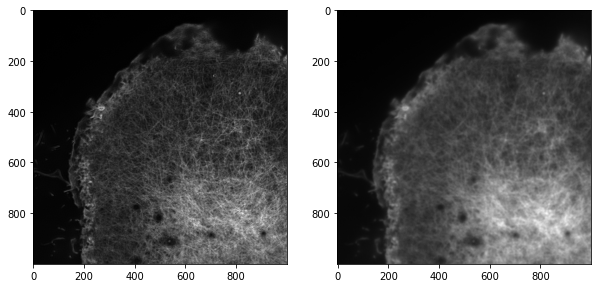

In [ ]:
hr_images = [io.imread(os.path.join(hr_data_filepath, filename)) for filename in os.listdir(hr_data_filepath) if filename.endswith(hr_extension)]
lr_images = [io.imread(os.path.join(lr_data_filepath, filename)) for filename in os.listdir(lr_data_filepath) if filename.endswith(lr_extension)]

imgs_to_predict = np.expand_dims([x[:500,:500] for x in lr_images],axis=-1)
grnd_imgs = np.expand_dims([x[:1000,:1000] for x in hr_images],axis=-1)

predictions = model.predict(imgs_to_predict)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(grnd_imgs[0,:,:,0], 'gray')
plt.subplot(1,2,2)
plt.imshow(predictions[0,:,:,0],'gray')

#### Dividing the work by mapping functions

In [ ]:
from skimage import filters
from skimage.util import random_noise
from scipy.ndimage.interpolation import zoom as npzoom
from skimage.util import img_as_ubyte

def em_crappify(img, scale):
    ''' Degradates and downscales the given image, simuating
        the degradation that a electron microscopy would suffer.
        Source https://www.biorxiv.org/content/10.1101/740548v3.
    Args:
        img (array): image that whose low resolution counterpart will be calcualted.
        scale (int): scale factor for the image downscaling. Example: 2.
    Returns:
        Low resolution image obtained from degradatin the received high resolution image.
    '''
    img = filters.gaussian(img, sigma=3) + 1e-6
    return npzoom(img, 1/scale, order=1)

def fluo_crappify(img,scale):
    ''' Degradates and downscales the given image, simuating
        the degradation that a fluorescence microscopy would suffer.
        Source https://www.biorxiv.org/content/10.1101/740548v3.
    Args:
        img (array): image that whose low resolution counterpart will be calcualted.
        scale (int): scale factor for the image downscaling. Example: 2.
    Returns:
        Low resolution image obtained from degradatin the received high resolution image.
    '''
    img = random_noise(img, mode='salt', amount=0.005)
    img = random_noise(img, mode='pepper', amount=0.005)
    img = filters.gaussian(img, sigma=5) + 1e-10
    return npzoom(img, 1/scale, order=1)

class MicroscopyDataset_2:
    def __init__(self, patch_size_x, patch_size_y,
                 down_factor,
                 validation=False, validation_split=None,
                 hr_imgs_basedir="", lr_imgs_basedir="",
                 only_high_resolution_data=False,
                 only_hr_imgs_basedir="",
                 type_of_data="Electron microscopy"):

        if only_high_resolution_data:
            used_hr_imgs_basedir = only_hr_imgs_basedir
        else:
            used_hr_imgs_basedir = hr_imgs_basedir

        _, hr_extension = os.path.splitext(os.listdir(used_hr_imgs_basedir)[0])

        hr_filenames = [used_hr_imgs_basedir + '/' + x for x in os.listdir(used_hr_imgs_basedir) if x.endswith(hr_extension)]
        hr_filenames.sort()

        if validation_split is not None:
            val_files = int(len(hr_filenames) * validation_split)
            if validation:
                self.hr_img_names = hr_filenames[:val_files]
            else:
                self.hr_img_names = hr_filenames[val_files:]
        else:
            self.hr_img_names = hr_filenames

        if not only_high_resolution_data:
            _, lr_extension = os.path.splitext(os.listdir(lr_imgs_basedir)[0])

            lr_filenames = [lr_imgs_basedir + '/' + x for x in os.listdir(lr_imgs_basedir) if x.endswith(lr_extension)]
            lr_filenames.sort()

            if validation_split is not None:
                val_lr_files = int(len(lr_filenames) * validation_split)
                if validation:
                    self.lr_img_names = lr_filenames[:val_lr_files]
                else:
                    self.lr_img_names = lr_filenames[val_lr_files:]
            else:
                self.lr_img_names = lr_filenames


        self.only_high_resolution_data = only_high_resolution_data

        self.down_factor = down_factor
        self.type_of_data = type_of_data

        self.lr_patch_size_x = patch_size_x
        self.lr_patch_size_y = patch_size_y
        self.hr_patch_size_x = patch_size_x * down_factor
        self.hr_patch_size_y = patch_size_y * down_factor

        self.lr_shape = io.imread(self.hr_img_names[0]).shape[0]//down_factor

    def hr_to_lr(self, hr_img, down_factor, type_of_data):

        if type_of_data == "Electron microscopy":
            lr_img = em_crappify(hr_img, down_factor)
        else:
            lr_img = fluo_crappify(hr_img, down_factor)
        return lr_img

    def __len__(self):
        return len(self.hr_img_names) * (self.lr_shape//self.lr_patch_size_x)**2

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_idx = idx // (self.lr_shape//self.lr_patch_size_x)**2

        hr_img = img_as_ubyte(io.imread(self.hr_img_names[img_idx]))

        if self.only_high_resolution_data:
            lr_img = self.hr_to_lr(hr_img, self.down_factor, self.type_of_data)
        else:
            lr_img = img_as_ubyte(io.imread(self.lr_img_names[img_idx])) / 255.0

        hr_img = hr_img / 255.0

        hr_img = hr_img.astype(np.float32)
        lr_img = lr_img.astype(np.float32)

        lr_idx_x = np.random.randint(0, lr_img.shape[0] - self.lr_patch_size_x)
        lr_idx_y = np.random.randint(0, lr_img.shape[1] - self.lr_patch_size_y)

        lr_patch = lr_img[lr_idx_x : lr_idx_x + self.lr_patch_size_x,
                          lr_idx_y : lr_idx_y + self.lr_patch_size_y]
        lr_patch = lr_patch[:,:,np.newaxis]

        hr_idx_x = lr_idx_x * self.down_factor
        hr_idx_y = lr_idx_y * self.down_factor

        hr_patch = hr_img[hr_idx_x : hr_idx_x + self.hr_patch_size_x,
                          hr_idx_y : hr_idx_y + self.hr_patch_size_x]

        hr_patch = hr_patch[:,:,np.newaxis]

        return lr_patch, hr_patch

    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)


def transform(lr, hr, horizontal_flip=False, vertical_flip=False,
              rotation=False):
    rng = np.random.default_rng()
    if horizontal_flip:
        if rng.random() < 0.5:
            lr = tf.image.flip_left_right(lr)
            hr = tf.image.flip_left_right(hr)

    if vertical_flip:
        if rng.random() < 0.5:
            lr = tf.image.flip_up_down(lr)
            hr = tf.image.flip_up_down(hr)

    if rotation:
        if rng.random() < 0.5:
            k = rng.integers(3) + 1

            lr = tf.image.rot90(lr, k=k)
            hr = tf.image.rot90(hr, k=k)

    return  lr, hr

In [ ]:
list_take_1 = list(ds.take(1))

In [ ]:
lr, hr = list_take_1[0]

In [ ]:
lr.shape

TensorShape([32, 128, 128, 1])

In [ ]:
mem_report()

patch_size = 128
down_factor = 2
validation_split = 0.1
hr_imgs_basedir = hr_data_filepath
lr_imgs_basedir = lr_data_filepath
only_high_resolution_data = False
only_hr_images_basedir= ""
type_of_data = "Electron microscopy"

data_generator = MicroscopyDataset_2(patch_size, patch_size, down_factor,
                            validation=False, validation_split=validation_split,
                            hr_imgs_basedir=hr_imgs_basedir, lr_imgs_basedir=lr_imgs_basedir,
                            only_high_resolution_data=only_high_resolution_data,
                            only_hr_imgs_basedir=only_hr_images_basedir,
                            type_of_data=type_of_data)

ds = tf.data.Dataset.from_generator(data_generator,
                                    output_types=(tf.float64,tf.float64))
batch_size = 32
ds = ds.shuffle(np.round(data_generator.__len__()*0.2))
ds = ds.batch(batch_size)
de = ds.map(lambda lr, hr:transform(lr, hr, horizontal_flip=True, vertical_flip=True,rotation=True))
ds = ds.prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
model.fit(ds, epochs=5)

mem_report()

Using device: cuda

CPU RAM Free: 10.5 GB
GPU 0 ... Mem Free: 14731MB / 15109MB | Utilization   3%
Epoch 1/5


KeyboardInterrupt: ignored

In [ ]:
mem_report()

patch_size = 128
down_factor = 2
validation_split = 0.1
hr_imgs_basedir = hr_data_filepath
lr_imgs_basedir = lr_data_filepath
only_high_resolution_data = False
only_hr_images_basedir= ""
type_of_data = "Electron microscopy"

data_generator = MicroscopyDataset_2(patch_size, patch_size, down_factor,
                            validation=False, validation_split=validation_split,
                            hr_imgs_basedir=hr_imgs_basedir, lr_imgs_basedir=lr_imgs_basedir,
                            only_high_resolution_data=only_high_resolution_data,
                            only_hr_imgs_basedir=only_hr_images_basedir,
                            type_of_data=type_of_data)

ds = tf.data.Dataset.from_generator(data_generator,
                                    output_types=(tf.float64,tf.float64))
batch_size = 32
ds = ds.shuffle(np.round(data_generator.__len__()*0.2))
ds = ds.batch(batch_size)
de = ds.map(lambda lr, hr:transform(lr, hr, horizontal_flip=True, vertical_flip=True,rotation=True),
            num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
model.fit(ds, epochs=5)

mem_report()

Using device: cuda

CPU RAM Free: 10.1 GB
GPU 0 ... Mem Free: 13235MB / 15109MB | Utilization  12%
Epoch 1/5
64/64 [==============================] - 141s 2s/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 2/5
64/64 [==============================] - 141s 2s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/5
64/64 [==============================] - 140s 2s/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/5
64/64 [==============================] - 139s 2s/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 5/5
64/64 [==============================] - 139s 2s/step - loss: 0.0024 - mean_squared_error: 0.0024
Using device: cuda

CPU RAM Free: 10.1 GB
GPU 0 ... Mem Free: 13235MB / 15109MB | Utilization  12%


In [ ]:
patch_size = 64
down_factor = 2
validation_split = 0.1
hr_imgs_basedir = '/content/Untitled Folder'
lr_imgs_basedir = '/content/Untitled Folder 1'
only_high_resolution_data = False
only_hr_images_basedir= ""
type_of_data = "Electron microscopy"

data_generator = MicroscopyDataset_2(patch_size, patch_size, down_factor,
                            validation=False, validation_split=validation_split,
                            hr_imgs_basedir=hr_imgs_basedir, lr_imgs_basedir=lr_imgs_basedir,
                            only_high_resolution_data=only_high_resolution_data,
                            only_hr_imgs_basedir=only_hr_images_basedir,
                            type_of_data=type_of_data)

ds = tf.data.Dataset.from_generator(data_generator,
                                    output_types=(tf.float64,tf.float64))
batch_size = 32
ds = ds.shuffle(np.round(data_generator.__len__()*0.2))
ds = ds.batch(batch_size)
de = ds.map(lambda lr, hr:transform(lr, hr, horizontal_flip=True, vertical_flip=True,rotation=True),
            num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.prefetch(tf.data.AUTOTUNE)


ultimate_ds = tf.data.Dataset.range(2).interleave(
                lambda _: ds,
                num_parallel_calls=tf.data.AUTOTUNE
              )

inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
model.fit(ultimate_ds, epochs=5)

Epoch 1/5
340/340 [==============================] - 76s 195ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 2/5
340/340 [==============================] - 74s 199ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 3/5
340/340 [==============================] - 72s 193ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/5
340/340 [==============================] - 74s 200ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/5
340/340 [==============================] - 92s 237ms/step - loss: 0.0025 - mean_squared_error: 0.0025


### With Sequence

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class CIFAR10Sequence(tf.keras.utils.Sequence):

    def __init__(self, lr_path, hr_path, batch_size):
        _, lr_extension = os.path.splitext(os.listdir(lr_path)[0])
        _, hr_extension = os.path.splitext(os.listdir(hr_path)[0])
        self.lr_filenames = [os.path.join(lr_path, filename) for filename in os.listdir(lr_path) if filename.endswith(lr_extension)]
        self.hr_filenames = [os.path.join(hr_path, filename) for filename in os.listdir(hr_path) if filename.endswith(hr_extension)]

        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.hr_filenames) / self.batch_size)

    def __getitem__(self, idx):

        batch_x = self.lr_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.hr_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        lr_image = [np.expand_dims(io.imread(filename)[0:100, 0:100], axis=-1) for filename in batch_x]
        hr_image = [np.expand_dims(io.imread(filename)[0:200, 0:200], axis=-1) for filename in batch_y]


        return np.array(lr_image), np.array(hr_image)


In [ ]:
sequence = CIFAR10Sequence(lr_data_filepath, hr_data_filepath, 8)
model.fit(sequence, epochs=10)

Epoch 1/10
32/32 [==============================] - 20s 627ms/step - loss: 142601728.0000 - mean_squared_error: 142601744.0000
Epoch 2/10
32/32 [==============================] - 21s 653ms/step - loss: 135765104.0000 - mean_squared_error: 135765104.0000
Epoch 3/10
32/32 [==============================] - 21s 641ms/step - loss: 128495208.0000 - mean_squared_error: 128495208.0000
Epoch 4/10
32/32 [==============================] - 20s 630ms/step - loss: 122518320.0000 - mean_squared_error: 122518328.0000
Epoch 5/10
32/32 [==============================] - 20s 634ms/step - loss: 119373416.0000 - mean_squared_error: 119373424.0000
Epoch 6/10
32/32 [==============================] - 20s 623ms/step - loss: 118558216.0000 - mean_squared_error: 118558224.0000
Epoch 7/10
32/32 [==============================] - 20s 628ms/step - loss: 118134192.0000 - mean_squared_error: 118134200.0000
Epoch 8/10
32/32 [==============================] - 21s 649ms/step - loss: 118264936.0000 - mean_squared_error:

8/8 [==============================] - 16s 2s/step


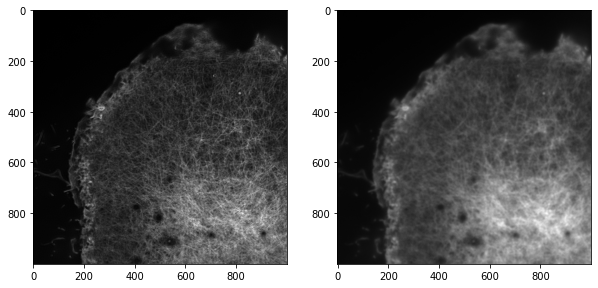

In [ ]:
imgs_to_predict = np.expand_dims([x[:500,:500] for x in lr_images],axis=-1)
grnd_imgs = np.expand_dims([x[:1000,:1000] for x in hr_images],axis=-1)
predictions = model.predict(imgs_to_predict)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(grnd_imgs[0,:,:,0], 'gray')
plt.subplot(1,2,2)
plt.imshow(predictions[0,:,:,0],'gray')

### As I was doing with ImageGenerator

Using device: cuda

CPU RAM Free: 12.0 GB
GPU 0 ... Mem Free: 15106MB / 15109MB | Utilization   0%
Epoch 1/5
64/64 [==============================] - 15s 102ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 2/5
64/64 [==============================] - 7s 106ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/5
64/64 [==============================] - 7s 108ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 4/5
64/64 [==============================] - 7s 103ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/5
64/64 [==============================] - 7s 102ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Using device: cuda

CPU RAM Free: 5.9 GB
GPU 0 ... Mem Free: 13243MB / 15109MB | Utilization  12%


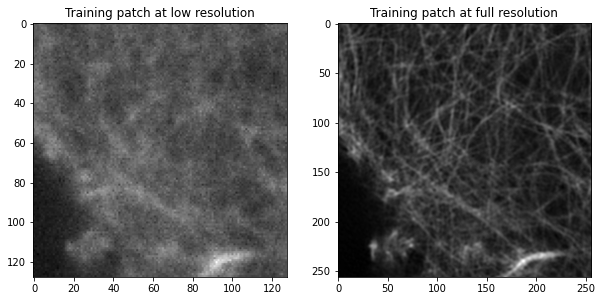

In [ ]:
from skimage import transform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

def em_crappify(img, scale):
    ''' Degradates and downscales the given image, simuating
        the degradation that a electron microscopy would suffer.
        Source https://www.biorxiv.org/content/10.1101/740548v3.
    Args:
        img (array): image that whose low resolution counterpart will be calcualted.
        scale (int): scale factor for the image downscaling. Example: 2.
    Returns:
        Low resolution image obtained from degradatin the received high resolution image.
    '''
    img = filters.gaussian(img, sigma=3) + 1e-6
    return npzoom(img, 1/scale, order=1)

def fluo_crappify(img,scale):
    ''' Degradates and downscales the given image, simuating
        the degradation that a fluorescence microscopy would suffer.
        Source https://www.biorxiv.org/content/10.1101/740548v3.
    Args:
        img (array): image that whose low resolution counterpart will be calcualted.
        scale (int): scale factor for the image downscaling. Example: 2.
    Returns:
        Low resolution image obtained from degradatin the received high resolution image.
    '''
    img = random_noise(img, mode='salt', amount=0.005)
    img = random_noise(img, mode='pepper', amount=0.005)
    img = filters.gaussian(img, sigma=5) + 1e-10
    return npzoom(img, 1/scale, order=1)

###

def calculate_down_factor (lr_imgs_basedir, hr_imgs_basedir):
    _, hr_extension = os.path.splitext(os.listdir(hr_imgs_basedir)[0])
    hr_filenames = [hr_imgs_basedir + '/' + x for x in os.listdir(hr_imgs_basedir) if x.endswith(hr_extension)]

    _, lr_extension = os.path.splitext(os.listdir(lr_imgs_basedir)[0])
    lr_filenames = [lr_imgs_basedir + '/' + x for x in os.listdir(lr_imgs_basedir) if x.endswith(lr_extension)]

    hr_img = io.imread(hr_filenames[0])
    lr_img = io.imread(lr_filenames[0])

    down_scale_x = hr_img.shape[0] / lr_img.shape[0]
    down_scale_y = hr_img.shape[1] / lr_img.shape[1]

    return [down_scale_x, down_scale_y]

###

# We define a method to create an arbitrary number of random crops of
# a given size

def hr_to_lr(hr_img, down_factor, type_of_data):

    if type_of_data == "Electron microscopy":
        lr_img = em_crappify(hr_img, down_factor)
    else:
        lr_img = fluo_crappify(hr_img, down_factor)
    return lr_img

def create_random_patches(lr_path, hr_path, only_hr, type_hr_data,
                          only_hr_path, down_factor, num_patches,
                          lr_patch_size_width, lr_patch_size_height):
  ''' Create a list of images patches out of a list of images
  Args:
      lr_path (string): low resolution (LR) image path (input images).
      hr_path (string): high resolution (HR) image path (ground truth images).
      only_hr (boolean): indicates if only HR images will be used.
      type_hr_data (string): in case only HR images would be used, what type of data they would be (Electron microscopy or Fluorescence).
      only_hr_path (string): in case only HR images would be used, HR image path (ground truth images).
      down_factor (int): scale factor between LR and HR images. Example: 2.
      lr_patch_size_width (int): width of the LR patches.
      lr_patch_size_height (int): height of the LR patches.

  Returns:
      list of image patches (LR) and patches of corresponding labels (HR)
  '''
  if only_hr:
    hr_path = only_hr_path

  _, extension = os.path.splitext(os.listdir(hr_path)[0])
  filenames = [x for x in os.listdir(hr_path) if x.endswith(extension)]
  filenames.sort()

  hr_shape = io.imread(hr_path + '/' + filenames[0]).shape
  #num_patches = len(filenames) * ((hr_shape[0]//down_factor)//lr_patch_size_width)**2

  input_patches = []
  output_patches = []
  for file_idx in range(len(filenames)):

    hr_img = img_as_ubyte(io.imread(hr_path + '/' + filenames[file_idx]))

    if only_hr:
      # If no path to the LR images is given, they will be artificially generated
      lr_img = hr_to_lr(hr_img, down_factor, type_hr_data)
      # lr_img is not normalized because the crappify function already normalizes it
    else:
      lr_img = img_as_ubyte( io.imread( lr_path + '/' + filenames[file_idx] ) ) / 255.0

    hr_img = hr_img / 255.0

    if lr_img.shape[0] - lr_patch_size_width <= 0:
      lr_patch_size_width = lr_img.shape[0] - 1
    if lr_img.shape[1] - lr_patch_size_height <= 0:
      lr_patch_size_height = lr_img.shape[1] - 1

    for i in range(num_patches):
      lr_idx_width = np.random.randint(0, lr_img.shape[0] - lr_patch_size_width)
      lr_idx_height = np.random.randint(0, lr_img.shape[1] - lr_patch_size_height)
      hr_idx_width = lr_idx_width * down_factor
      hr_idx_height = lr_idx_height * down_factor

      input_patches.append(lr_img[lr_idx_width : lr_idx_width + lr_patch_size_width,
                                  lr_idx_height : lr_idx_height + lr_patch_size_height])
      output_patches.append(hr_img[hr_idx_width : hr_idx_width + lr_patch_size_width * down_factor,
                                  hr_idx_height : hr_idx_height + lr_patch_size_height * down_factor])

  return input_patches, output_patches

def create_complete_images( lr_path, hr_path, only_hr,
                           type_hr_data, only_hr_path, down_factor):
  ''' Create a list of images patches out of a list of images
  Args:
      lr_path (string): low resolution (LR) image path (input images).
      hr_path (string): high resolution (HR) image path (ground truth images).
      only_hr (boolean): indicates if only HR images will be used.
      type_hr_data (string): in case only HR images would be used, what type of data they would be (Electron microscopy or Fluorescence).
      only_hr_path (string): in case only HR images would be used, HR image path (ground truth images).
      down_factor (int): scale factor between LR and HR images. Example: 2.

  Returns:
      list of image patches (LR) and patches of corresponding labels (HR)
  '''

  return create_random_patches(lr_path, hr_path, only_hr, type_hr_data,
                              only_hr_path, down_factor, 1, np.inf, np.inf)

###

# Random rotation of an image by a multiple of 90 degrees
def random_90rotation( img ):
  return transform.rotate(img, 90*np.random.randint( 0, 5 ), preserve_range=True)

# Runtime data augmentation
def get_train_val_generators(X_data, Y_data, validation_split=0.25,
                             batch_size=32, seed=42, show_examples=False,
                             rotation=True, horizontal_flip=True, vertical_flip=True ):
  X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                      Y_data,
                                                      train_size=1-validation_split,
                                                      test_size=validation_split,
                                                      random_state=seed, shuffle=False)

  random_rotation=random_90rotation
  if not rotation:
    random_rotation=None

  # Image data generator distortion options
  data_gen_args = dict( preprocessing_function=random_rotation,
                        horizontal_flip=horizontal_flip,
                        vertical_flip=vertical_flip,
                        fill_mode='reflect')

  # Train data, provide the same seed and keyword arguments to the fit and flow methods
  X_datagen = ImageDataGenerator(**data_gen_args)
  Y_datagen = ImageDataGenerator(**data_gen_args)
  X_datagen.fit(X_train, augment=True, seed=seed)
  Y_datagen.fit(Y_train, augment=True, seed=seed)
  X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
  Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)


  # Validation data, no data augmentation, but we create a generator anyway
  X_datagen_val = ImageDataGenerator()
  Y_datagen_val = ImageDataGenerator()
  X_datagen_val.fit(X_test, augment=True, seed=seed)
  Y_datagen_val.fit(Y_test, augment=True, seed=seed)
  X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=False, seed=seed)
  Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=False, seed=seed)

  if show_examples:
    plt.figure(figsize=(10,10))
    # generate samples and plot
    for i in range(9):
      # define subplot
      plt.subplot(330 + 1 + i)
      # generate batch of images
      batch = X_train_augmented.next()
      # convert to unsigned integers for viewing
      image = batch[0]
      # plot raw pixel data
      plt.imshow(image[:,:,0], vmin=0, vmax=1, cmap='gray')
    # show the figure
    plt.show()
    X_train_augmented.reset()

  # combine generators into one which yields image and masks
  train_generator = zip(X_train_augmented, Y_train_augmented)
  test_generator = zip(X_test_augmented, Y_test_augmented)

  return train_generator, test_generator

#################################################

mem_report()

patch_size = 128
down_factor = 2
validation_split = 0.1
hr_imgs_basedir = hr_data_filepath
lr_imgs_basedir = lr_data_filepath
only_high_resolution_data = False
only_hr_images_basedir= ""
type_of_data = "Electron microscopy"
batch_size=32

# Read the list of file names, same for source and target
train_patches_wf, train_patches_gt = create_random_patches(lr_imgs_basedir,
                                                           hr_imgs_basedir,
                                                           only_high_resolution_data,
                                                           type_of_data,
                                                           only_hr_images_basedir,
                                                           down_factor,
                                                           16,
                                                           patch_size,
                                                           patch_size)
# display patch
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow( train_patches_wf[0], 'gray' )
plt.title( 'Training patch at low resolution' )
# Side by side with its "ground truth"
plt.subplot(1, 2, 2)
plt.imshow( train_patches_gt[0], 'gray' )
plt.title( 'Training patch at full resolution' )
plt.savefig('/content/ExampleData.png', bbox_inches='tight', pad_inches=0)


# Prepare the training data and create data generators
# training input
X_train = train_patches_wf.copy()
X_train = np.expand_dims(X_train, axis=-1)
# training ground truth
Y_train = train_patches_gt.copy()
Y_train = np.expand_dims(Y_train, axis=-1)

# Calculate the number of steps to use for validation
validation_steps = np.ceil(len(X_train)*validation_split/batch_size)

# define data generators
train_generator, val_generator = get_train_val_generators(X_data=X_train,
                                                          Y_data=Y_train,
                                                          validation_split=validation_split,
                                                          batch_size=batch_size,
                                                          show_examples=False,
                                                          rotation=True,
                                                          horizontal_flip=True,
                                                          vertical_flip=True)


inputs = tf.keras.layers.Input(shape=(None,None,1))
x = tf.keras.layers.Conv2D(4, (1,1))(inputs)
x = tf.keras.layers.Conv2DTranspose(16, (2, 2),
                    strides=(2, 2), padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, (1,1))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
model.fit(train_generator, steps_per_epoch=64, epochs=5)

mem_report()